# Email (Gmail Agent)

In [8]:
import os
import base64
import quopri
import json
from typing_extensions import TypedDict
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from langchain_ollama import ChatOllama
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver



In [32]:
SCOPES = [
    "https://www.googleapis.com/auth/gmail.modify",
    "https://www.googleapis.com/auth/gmail.send",
]

def get_credentials():
    creds = None
    token_path = "token.json"
    if os.path.exists(token_path):
        with open(token_path, "r") as token:
            try:
                creds_info = json.load(token)
                creds = Credentials.from_authorized_user_info(creds_info)
            except json.JSONDecodeError:
                creds = None
    if creds and creds.valid and creds.has_scopes(SCOPES):
        return creds
    else:
        if os.path.exists(token_path):
            os.remove(token_path)
        flow = InstalledAppFlow.from_client_secrets_file("credentials.json", SCOPES)
        creds = flow.run_local_server(port=0)
        with open(token_path, "w") as token:
            token.write(creds.to_json())
        return creds
creds = get_credentials()
service = build("gmail","v1", credentials=creds)


Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=695017471601-e5ub70ecs0s1ktav3dbrdghb5d6he9te.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A58619%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fgmail.modify+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fgmail.send&state=mxXj3QDMTu5Gz7mcH1mtZcZgOdDv9d&access_type=offline


In [33]:
def send_email(service, to, subject, message_text, user_id="me"):
    message = MIMEMultipart()
    message["to"] = to
    message["subject"] = subject
    message.attach(MIMEText(message_text, "plain"))
    raw = base64.urlsafe_b64encode(message.as_bytes()).decode()
    message_body = {"raw": raw}
    sent_message = (
        service.users().messages().send(userId=user_id, body=message_body).execute()
    )
    print(f"Email sent: ID {sent_message['id']}")

In [34]:
def get_email_body(payload):
    def decode_part(part):
        body = part.get('body', {}).get('data', '')
        if body:
            data = base64.urlsafe_b64decode(body.encode('UTF-8'))
            if part.get('mimeType') == 'text/plain':
                return data.decode('UTF-8')
            elif part.get('mimeType') == 'text/html':
                return quopri.decodestring(data).decode('UTF-8')
        elif 'parts' in part:
            return ''.join([decode_part(p) for p in part['parts']])
        return ''
    return decode_part(payload)


In [35]:
def get_or_create_label(service, label_name):
    labels = service.users().labels().list(userId="me").execute().get('labels', [])
    label = next((label for label in labels if label['name'] == label_name), None)
    if label:
        return label['id']
    else:
        label_body = {
            'name': label_name,
            'labellistVisibility': 'labelShow',
            'messagelistVisibility': 'show',
            'type': 'user'
        }
        label = service.users().labels().create(userId='me', body=label_body).execute()
        return label['id']

# Create Agent

In [36]:
class AgentState(TypedDict):
    initialized: bool
    new_email: dict
    email_classification: str
    llm_outpout: str
    processed_email_ids: list[str]

In [49]:
def check_for_new_emails(state: AgentState):
    print("State in 'check_for_new_emails':", state)
    if not state.get('initialized', False):
        print("Initializing state for the first time...")
        state['initialized'] = True
        results = service.users().messages().list(userId='me', labelIds=['INBOX'], maxResults=10).execute()
        messages = results.get('messages', [])
        state['processed_email_ids'] = [msg['id'] for msg in messages]
        state['new_email'] = None
        print("Initial emails marked as processed:", state['processed_email_ids'])
        return state
    results = service.users().messages().list(userId='me', labelIds=['INBOX'], maxResults=10).execute()
    messages = results.get('messages', [])
    processed_ids = set(state.get('processed_email_ids', []))
    emails_to_process = [msg for msg in messages if msg['id'] not in processed_ids]
    if emails_to_process:
        email_id = emails_to_process[0]['id']
        email = service.users().messages().get(userId='me', id=email_id, format='full').execute()
        state['new_email'] = email
    else:
        state['new_email'] = None
    print("Updated state in 'check_for_new_emails':", state)
    return state

In [50]:
class GradeEmail(BaseModel):
    score: str = Field(description="Is the email normal? if yes -> 'Yes', if not -> 'No'")

def classify_email(state: AgentState):
    email = state.get('new_email')
    if not email:
        state['email_classification'] = 'No new email'
        return state
    payload = email.get('payload', {})
    headers = payload.get('headers', [])
    subject = next((header['value'] for header in headers if header['name'] == 'Subject'), '')
    sender = next((header['value'] for header in headers if header['name'] == 'From'), '')
    body = get_email_body(payload)
    email_content = f"From: {sender}\nSubject: {subject}\n\n{body}"
    system_prompt = """You are an assistant that classifies emails. If the the email sounds like it comes from a real person, classify it as
    Yes - e.g., an email from freinds and colleagues. 
    No - e.g. a mail confirming a registration or other automaticallt generated mails or emails from unverified domains"""
    grade_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            ("human", "Email content:\n\n{email_content}\n\nIs this a normal email? 'Yes' or 'No'?"),
        ]
    )
    llm = ChatOllama(model="llama3.2")
    structured_llm = llm.with_structured_output(GradeEmail)
    classifier = grade_prompt | structured_llm
    result = classifier.invoke({"email_content": email_content})
    state['email_classification'] = result.score
    print("Update state in 'classify_email':", state)
    return state


In [51]:
def classification_router(state: AgentState):
    classification = state.get('email_classification', '').lower()
    if classification == 'yes':
        return 'generate_response'
    elif classification == 'no':
        return 'flag_email'
    else:
        raise ValueError("Invalid classification value: {classification}")
    

In [52]:
def new_email_router(state: AgentState):
    if not state.get('initialized', False):
        return "__end__"
    elif state.get('new_email'):
        return 'classify_email'
    else:
        return '__end__'

In [53]:
def generate_response(state : AgentState):
    email = state.get('new_email')
    payload = email.get('payload', {})
    headers = payload.get('headers', [])
    subject = next((header['value'] for header in headers if header['name'] == 'Subject'), '')
    sender = next((header['value'] for header in headers if header['name'] == 'From'), '')
    body = get_email_body(payload)
    email_content = f"From: {sender}\nSubject: {subject}\n\n{body}"
    system_prompt = """You are an assistant that generates email replies. Respond politely in English. Just write the email how you would response as if you were me. Like 'Dear Mr. x, thanks for your email...'. Only provide the text, no intro like 'Here is the polite reply:' or any other introduction!"""
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            ("human", "Email content:\n\n{email_content}\n\nWrite a polite reply."),
        ]
    )
    llm = ChatOllama(model="llama3.2")
    chain = prompt | llm | StrOutputParser()
    response = chain.invoke({"email_content": email_content})
    state['llm_output'] = response
    print("Updated state in 'generate_response':", state)
    return state

In [54]:
def send_email_response(state: AgentState):
    email = state.get('new_email')
    if not email:
        print("No new email to send a response to.")
        return state
    payload = email.get('payload', {})
    headers = payload.get('headers', [])
    sender = next((header['value'] for header in headers if header['name'] == 'From'), '')
    subject = next((header['value'] for header in headers if header['name'] == 'Subject'), 'No Subject')
    message_text = state.get('llm_output', '')
    send_email(service, sender, "Re: " + subject, message_text)
    print(f"Email sent in response to: {subject}, and state updated.")
    return state

In [55]:
def flag_email(state: AgentState):
    email = state.get('new_email')
    if not email:
        print("No email to flag.")
        return state
    email_id = email['id']
    classification = state.get('email_classification', '').lower()
    if classification == 'no':
        label_name = 'FLAGGED_NO'
    elif classification == 'yes':
        label_name = 'FLAGGED_YES'
    else:
        raise ValueError(f"Unexpected classification value: {classification}")
    label_id = get_or_create_label(service, label_name)
    service.users().messages().modify(
        userId='me',
        id=email_id,
        body={
            'addLabelIds': [label_id],
            'removeLabelIds': []
        }
    ).execute()
    service.users().messages().modify(
        userId='me',
        id=email_id,
        body={
            'removeLabelIds': ['UNREAD']
        }
    ).execute()
    state['new_email'] = None
    if 'processed_email_ids' not in state:
        state['processed_email_ids'] = []
    state['processed_email_ids'].append(email_id)
    print(f"Email flagged: ID {email_id}, and state updated.")
    return state

In [56]:
workflow = StateGraph(AgentState)
workflow.add_node('check_emails', check_for_new_emails)
workflow.add_node('classify_email', classify_email)
workflow.add_node('generate_response', generate_response)
workflow.add_node('send_response', send_email_response)
workflow.add_node('flag_email', flag_email)
workflow.add_conditional_edges('check_emails', new_email_router, {
    'classify_email': 'classify_email',
    '__end__': END
})
workflow.add_conditional_edges('classify_email', classification_router, {
    'generate_response': 'generate_response',
    'flag_email': 'flag_email'
})
workflow.add_edge('generate_response', 'send_response')
workflow.add_edge('send_response', 'flag_email')
workflow.add_edge('flag_email', END)
workflow.set_entry_point('check_emails')
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

In [57]:
config = {"configurable": {"thread_id": "1"}}

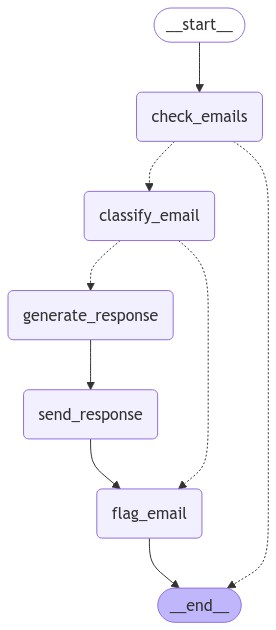

In [58]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [59]:
app.invoke({"initialized": False}, config=config)

State in 'check_for_new_emails': {'initialized': False}
Initializing state for the first time...
Initial emails marked as processed: ['192baa54d1f1cab9', '192baa29373b7438', '192ba68bc83c1b04', '192ba5f16cf68446', '192ba5e9694e26da', '192ba57558327ec7', '192ba4b26a977026', '192ba43e52c4daca', '192ba391fe2fd798', '192ba33170d95af5']


{'initialized': True,
 'new_email': None,
 'processed_email_ids': ['192baa54d1f1cab9',
  '192baa29373b7438',
  '192ba68bc83c1b04',
  '192ba5f16cf68446',
  '192ba5e9694e26da',
  '192ba57558327ec7',
  '192ba4b26a977026',
  '192ba43e52c4daca',
  '192ba391fe2fd798',
  '192ba33170d95af5']}

In [60]:
app.invoke({"initialized": True}, config=config)

State in 'check_for_new_emails': {'initialized': True, 'processed_email_ids': ['192baa54d1f1cab9', '192baa29373b7438', '192ba68bc83c1b04', '192ba5f16cf68446', '192ba5e9694e26da', '192ba57558327ec7', '192ba4b26a977026', '192ba43e52c4daca', '192ba391fe2fd798', '192ba33170d95af5']}
Updated state in 'check_for_new_emails': {'initialized': True, 'processed_email_ids': ['192baa54d1f1cab9', '192baa29373b7438', '192ba68bc83c1b04', '192ba5f16cf68446', '192ba5e9694e26da', '192ba57558327ec7', '192ba4b26a977026', '192ba43e52c4daca', '192ba391fe2fd798', '192ba33170d95af5'], 'new_email': None}


{'initialized': True,
 'new_email': None,
 'processed_email_ids': ['192baa54d1f1cab9',
  '192baa29373b7438',
  '192ba68bc83c1b04',
  '192ba5f16cf68446',
  '192ba5e9694e26da',
  '192ba57558327ec7',
  '192ba4b26a977026',
  '192ba43e52c4daca',
  '192ba391fe2fd798',
  '192ba33170d95af5']}

In [ ]:
import time

def run_email_checker(config):
    initialized = False
    first_iteration = True
    while True:
        try:
            app.invoke({"initialized": initialized}, config=config)
            initialized = True
        except Exception as e:
            print(f"An error occurred: {e}")

        if first_iteration:
            time.sleep(2)
            first_iteration = False
        else:
            time.sleep(15)

run_email_checker(config=config)